In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import OrdinalEncoder

In [59]:
# we need a GBM class for define the GBM model

class GBM:
    def __init__(self, n_estimators=100, max_depth=5, learning_rate=.1, min_samples_split=.75, subsample=.75, random_state=1001):
        '''
        This funcion is used to initilize a GBM classification model. Here, we also set some parameters with default values
        :param n_estimators: similar as n_tree in gbm function with R version
        :param max_depth: similar as interaction.depth in gbm function with R version
        :param learning_rate: usually with a small value, but at the cost of training time
        :param min_samples_split:similar with bag.fraction in R.
        :param subsample: similar like bag.fraction in R. 
        :param random_state: similar like set.seed() in R, to reproduce same results
        '''
        #GradientBoostingClassifier
        self.gbm = GradientBoostingClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            min_samples_split=min_samples_split,
            subsample=subsample,
            random_state=random_state
        )

    def fit(self, estimators_training, y):
        '''
        This function is used to training gbm model
        :param estimators_training: a matrix of estimator
        :param y: a matrix of wind damage events in training data set (n✕1 matrix)
        '''
        return self.gbm.fit(estimators_training, y)

    def predict(self, estimators_testing):
        '''
        This function is used to testing gbm model
        :param estimators_testing: a matrix of estimator in testing data set (n✕m matrix)
        '''
        output = self.gbm.predict(estimators_testing)
        return output

    def gbm_performance(self, estimators_testing, y):
        '''
        This function is used to get the performance of gbm. Here we used ROC to evaluate it.
        :param estimators_testing: a matrix of estimator (n✕m matrix)
        :param y: a matrix of estimator in testing data set (n✕1 matrix)
        '''
        predictions = self.gbm.predict(estimators_testing)
        accuracy = accuracy_score(y, predictions)
        print(f"accuracy is {accuracy *100}")


    def parameter_tuning(self, estimators_training, y, parameter_grid, cv=10):
        '''
        This function is used to get the best parameter combinations
        :param estimators_training: a matrix of estimator in training data set (n✕m matrix)
        :param y: a matrix of estimator in training data set (n✕1 matrix)
        :param parameter_grid: possible parameter conbinations, it is stored in a dict.
        :param cv: we used 10-fold cross validation to test the perfermance
        '''
        grid_search = GridSearchCV(self.gbm, parameter_grid, cv = 10)
        grid_search.fit(estimators_training, y)
        # update our gbm model
        self.gbm = grid_search.best_estimator_
        # print the parameters of teh best combinations
        print("Best: %f using %s !!!" %
              (grid_search.best_score_, grid_search.best_params_))

        return self.gbm

    def partial_plot(self, estimators_training,y, feature):
        '''
        This function is used to plot partial dependedce
        :param estimators_training: a matrix of estimator in training data set (n✕m matrix)
        :param feature: a list to indicate which variable is used to plot the partial dependence
        :param target: a int index to indicate which level of calss should be computed the partial depence plot. 
        '''
        est = self.gbm.fit(estimators_training, y)
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_title("Partial plot")
        PartialDependenceDisplay.from_estimator(
            est, estimators_training, feature, ax=ax, line_kw={"color": "red"})
        plt.show()

In [107]:
if __name__ == "__main__":
    mydata = pd.read_csv("BRTWindFinland_data2.csv")
    X = mydata.drop(columns=['storm', 'Unnamed: 0', 'X',
                    'poly_ID', 'dam_year', 'dam_H', 'dam_D'])
    #X = X.to_numpy()
    categorical_features= ['soiltype', 'developmentc','mainsp','fertilityc']
    enc = OrdinalEncoder()
    X[categorical_features] = enc.fit_transform(X[categorical_features])

    #for c in X.columns:
    #    if X[c].dtype == 'int64':
     #       X[c] = X[c].astype('category')
    
    y = mydata['storm'].astype('category')
   # y = y['storm'].values
    #y = y.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42,stratify=y)

    # add a model
    gbm_model = GBM()
    # Fit the model
    gbm_model.fit(X_train, y_train)
    predictions = gbm_model.predict(X_train)
    # training performance
    gbm_model.gbm_performance(X_train, y_train)
    # apply to testing data
    predictions = gbm_model.predict(X_test)
    print(confusion_matrix(y_test, predictions))
    gbm_model.gbm_performance(X_test, y_test)

    # parameter grid tuning
    '''
    param_grid = {
        'n_estimators': [200,400, 600, 800, 1000],
        #'learning_rate': [0.05, 0.1, 0.2],
        #'max_depth': [3, 5, 7],
        #'min_samples_split': [0.25,0.5,0.75]
    }
    '''
    # find the best parameter combinations
    # gbm_update = gbm_model.parameter_tuning(estimators_training=X_train, y=y_train,parameter_grid=param_grid)
    # check the performance of update model
    # gbm_update.gbm_performance(X_train, y_train)


accuracy is 98.26885643254101
[[78923     0]
 [ 1391     0]]
accuracy is 98.26804791194562


In [4]:
gbm_model_update = GBM(n_estimators=200) # update model
est1 = gbm_model_update.fit(X_train, y_train)
predictions = gbm_model_update.predict(X_test)
# training performance
accuracy = accuracy_score(y_test, predictions)
print(f"accuracy is {accuracy *100}")
#gbm_update.gbm_performance(X_test, y_test)

accuracy is 98.26804791194562


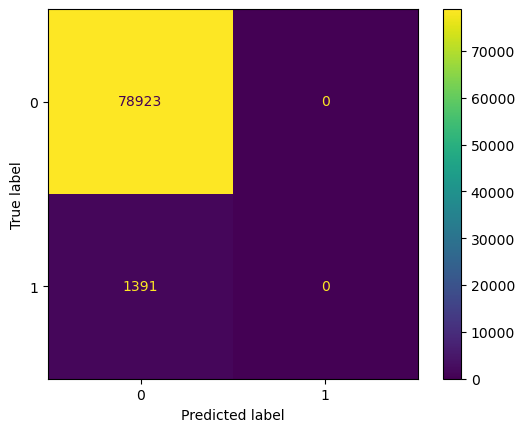

In [61]:
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions), display_labels = [0, 1])

cm_display.plot()
plt.show()

Since the data is super unbalanced, so we have to re-calculate the resampling ratio.....
**The results was misleading**

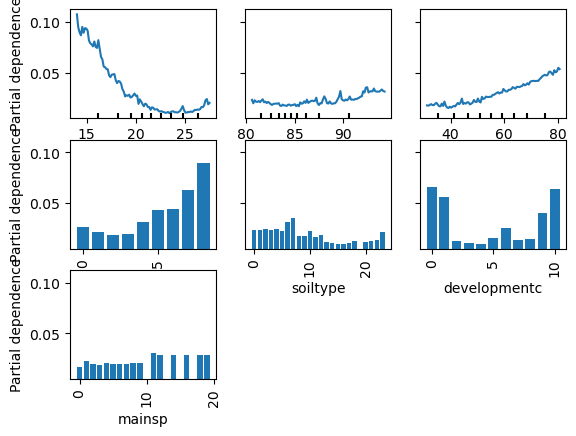

In [119]:

numerical_features = [
    "dam_age",
    "dam_G",
    "dam_ratioHD",
]

category_features = X_train.columns.drop(numerical_features)

features_info = {
    # features of interest
    "features": ['dam_G', 'dam_ratioHD', 'dam_age', 'fertilityc', 'soiltype','developmentc', 'mainsp'],
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    "categorical_features": ['fertilityc', 'soiltype','developmentc', 'mainsp'],
}

#gbm_model_update.partial_plot(X_train,y_train,[0,(0,1)])
PartialDependenceDisplay.from_estimator(
    rf.fit(X_train, y_train),
    X_train,#[0,1,2,3,4,5],
    target = 1,n_jobs=2,
   **features_info
    )

In [117]:
X_train.columns

Index(['dam_G', 'dam_ratioHD', 'dam_age', 'fertilityc', 'soiltype',
       'developmentc', 'mainsp'],
      dtype='object')

In [96]:
from pdpbox import pdp, info_plots

features = ['dam_G', 'dam_ratioHD', 'dam_age', 'fertilityc', 'soiltype','developmentc', 'mainsp']
pdp_plot= pdp.PDPIsolate(model=rf, 
                         df = mydata, 
                         model_features=features,
                         feature="soiltype",
                         feature_name="soiltype",
                         
                         )
pdp.pdp_plot(pdp_plot)
plt.show()


obtain pred_func from the provided model.


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [108]:
feat_imp = pd.Series(gbm_model.feature_importances_,index = X_train.columns).sort_values(ascending=True)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

AttributeError: 'GBM' object has no attribute 'feature_importances_'

In [89]:
target_soiltype= info_plots.TargetPlot(
    df=mydata,
    feature="fertilityc",
    feature_name="fertilityc",
    target=mydata['storm'].to_numpy()
)

TypeError: unhashable type: 'numpy.ndarray'

In [90]:
from sklearn.datasets import fetch_california_housing,
cal_housing = fetch_california_housing()

X = pd.DataFrame(cal_housing.data, columns=cal_housing.feature_names)
y = cal_housing.target

In [93]:
cal_housing

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]),
 'frame': None,
 'target_names': ['MedHouseVal'],
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': '.. _california_housing_dataset:\n

In [98]:
load_boston()

NameError: name 'load_boston' is not defined

In [106]:
mydata = pd.read_csv("BRTWindFinland_data2.csv")
X = mydata.drop(columns=['storm', 'Unnamed: 0', 'X',
                    'poly_ID', 'dam_year', 'dam_H', 'dam_D'])
    #X = X.to_numpy()
categorical_features= ['soiltype', 'developmentc','mainsp','fertilityc']
enc = OrdinalEncoder()
X[categorical_features] = enc.fit_transform(X[categorical_features])
print(X)


            dam_G  dam_ratioHD    dam_age  fertilityc  soiltype  developmentc  \
0       18.176471    96.916427  40.705882           1        10             7   
1       20.156250   103.992395  33.281250           2        70             7   
2       20.769231    96.956522  37.333333           2        10             7   
3       21.206395    91.502513  46.122093           2        10             7   
4       17.401302    97.716386  32.498915           2        10             7   
...           ...          ...        ...         ...       ...           ...   
321248  23.718750    86.184539  57.148438           3        21             7   
321249  25.769231    85.861500  61.884615           3        21             7   
321250  26.702381    84.668305  61.476190           3        21             7   
321251  24.666667    84.758065  61.066667           2        60             7   
321252  24.625000    84.784946  53.625000           2        20             7   

        mainsp  
0         

In [124]:
gbm = GradientBoostingClassifier()
gbm.fit(X_train, y_train)
#predictions = gbm.predict(X_train)
    # training performance
gbm.score(X_train, y_train)
    # apply to testing data
predictions = gbm.predict(X_test)
print(confusion_matrix(y_test, predictions))
gbm.score(X_test, y_test)
print(f"gbm train accuracy: {gbm.score(X_train, y_train):.3f}")
print(f"gbm test accuracy: {gbm.score(X_test, y_test):.3f}")

[[78919     4]
 [ 1391     0]]
gbm train accuracy: 0.983
gbm test accuracy: 0.983


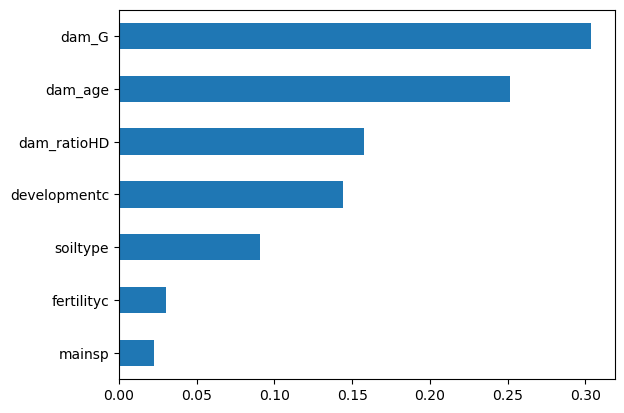

In [125]:
feat_importances = pd.Series(gbm.feature_importances_, index = X_train.columns).sort_values(ascending = True)
feat_importances.plot(kind = 'barh')
plt.show()

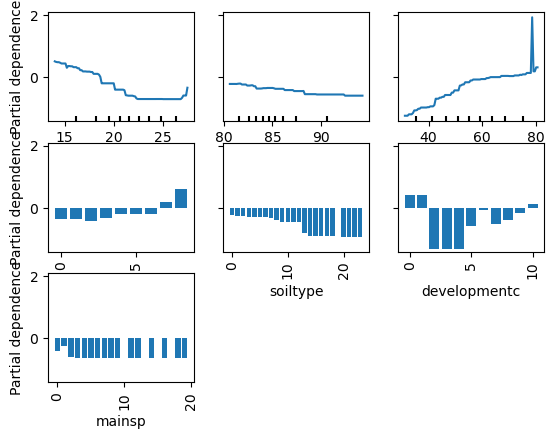

In [126]:
#gbm_model_update.partial_plot(X_train,y_train,[0,(0,1)])
PartialDependenceDisplay.from_estimator(
    gbm.fit(X_train, y_train),
    X_train,#[0,1,2,3,4,5],
    target = 1,n_jobs=2,
   **features_info
    )

In [114]:
rf = RandomForestClassifier(
         n_estimators=100,
         n_jobs=-1,
         min_samples_leaf = 1,
         oob_score=True,
         random_state = 42)
rf.fit(X_train, y_train)

print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")

RF train accuracy: 1.000
RF test accuracy: 0.983


<Axes: >

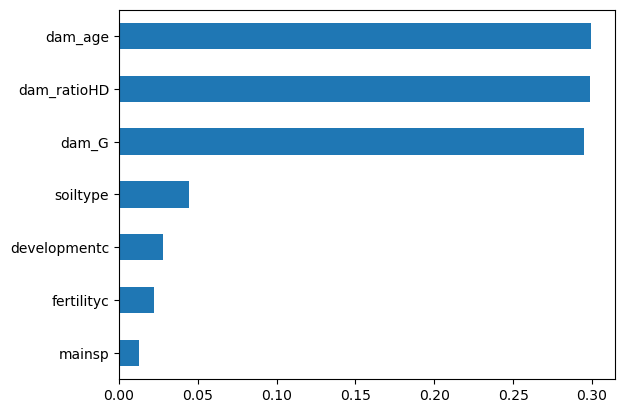

In [121]:

feat_importances = pd.Series(rf.feature_importances_, index = X_train.columns).sort_values(ascending = True)
feat_importances.plot(kind = 'barh')

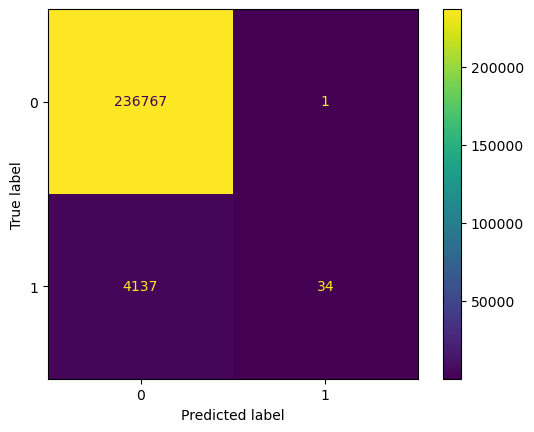

In [127]:
predictions = gbm.predict(X_train)
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_train, predictions), display_labels = [0, 1])

cm_display.plot()
plt.show()